# LowCarb thorax disease classification in Flower

## Check GPU availability

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Oct 22 23:20:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Imports

In [2]:
import os
import sys
import math
import time
from glob import glob
from PIL import Image
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import flwr as fl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nnqunt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torchvision import transforms as T, models

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")

Training on cuda:0


## Data

### Preprocess

In [3]:
root_img_dir = '/content/NIH/'

In [4]:
all_xray_df = pd.read_csv(
    os.path.join(
        root_img_dir,
        'Data_Entry_2017.csv'
        )
    )

all_image_paths = {
    os.path.basename(x): x for x in 
    glob(os.path.join(root_img_dir, 'images*', '*', '*.png'))
    }

print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
# all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x[:-1]))

all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
77244,00018972_037.png,Nodule,37,18972,52,F,AP,2500,2048,0.168,0.168,NaN,/content/NIH/images_009/images/00018972_037.png
80842,00019865_006.png,Effusion|Infiltration|Pleural_Thickening,6,19865,22,M,AP,3056,2544,0.139,0.139,NaN,/content/NIH/images_009/images/00019865_006.png
22371,00005935_001.png,Nodule,1,5935,53,M,PA,2500,2048,0.171,0.171,NaN,/content/NIH/images_003/images/00005935_001.png


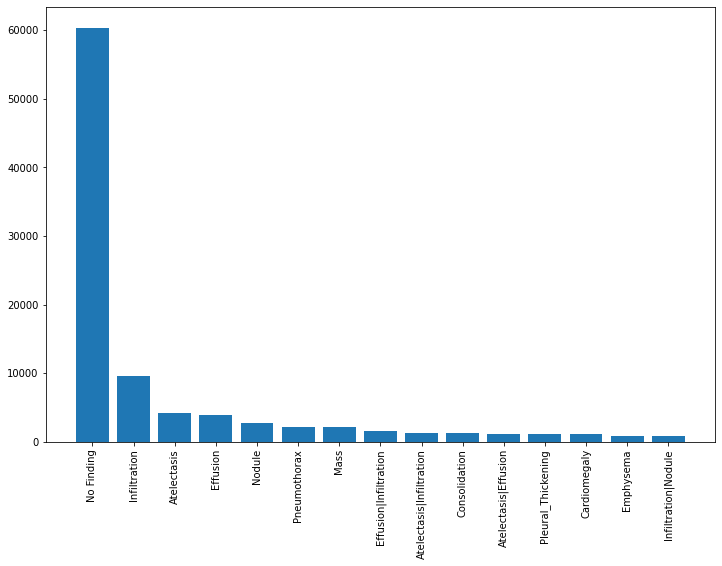

In [5]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [6]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
63177,00015606_024.png,,24,15606,18,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19097,00005069_009.png,Infiltration,9,5069,29,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
73050,00017994_004.png,Mass|Pneumothorax,4,17994,60,F,PA,2726,2521,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [7]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [
    c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES
    ]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (13) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


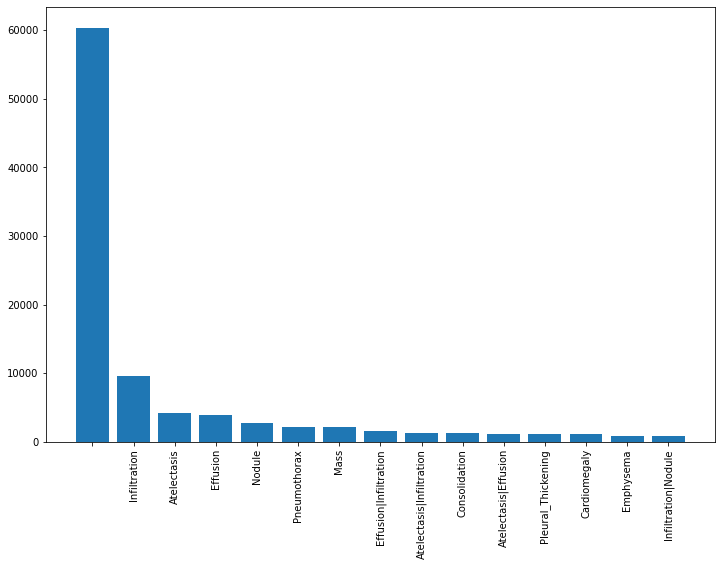

In [8]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()

all_xray_df = all_xray_df.sample(112120, weights=sample_weights)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

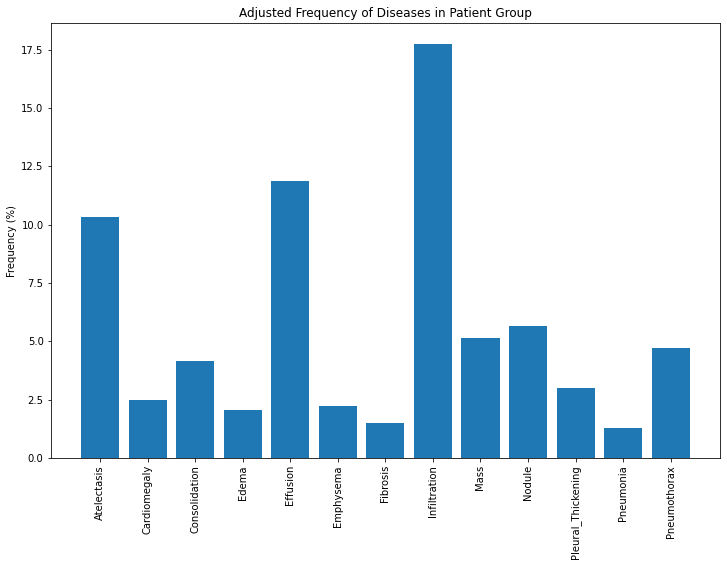

In [9]:
label_counts = 100*np.mean(all_xray_df[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

In [10]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [11]:
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,disease_vec
23949,00006304_033.png,,33,6304,67,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
96640,00025457_001.png,Infiltration,1,25457,54,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
93330,00023320_002.png,,2,23320,34,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [12]:
len(all_xray_df)

112120

### Get DataLoaders

In [13]:
class NIH_Dataset(Dataset):
  def __init__(
    self, 
    data_df,
    transform=None
    ):
    self.data_df = data_df
    self.transform = transform 

  def __len__(
    self
    ):
    return len(self.data_df)

  def __getitem__(
    self, 
    idx
    ):
    img_file = self.data_df['path'].iloc[idx]
    img = Image.open(img_file).convert('RGB')
    label = np.array(self.data_df.iloc[:,-1].iloc[idx], dtype=float)
    if self.transform:
        img = self.transform(img)

    return img, label

def get_data_loaders(
    data_df: pd.DataFrame,
    global_train_frac: float = 0.8,
    local_train_frac: float = 0.8,
    batch_size: int = 32,
    num_clients: int = 10
    ):
  train_data_transform = T.Compose([
    T.RandomRotation((-20,+20)),
    # T.Resize((512,512)),
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
                ])

  test_data_transform = T.Compose([
    T.Resize((512,512)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
                ])
  
  train_df, test_df = train_test_split(
      data_df,
      test_size = 1 - global_train_frac,
      random_state = 42,
      stratify = data_df['Finding Labels'].map( lambda x: x[:4])
  )

  trainset = NIH_Dataset(
      train_df,
      transform = train_data_transform
      )
  
  testset = NIH_Dataset(
      test_df,
      transform = test_data_transform
      )

  # Split training set into `num_clients` partitions to simulate different local datasets
  partition_size = len(trainset) // num_clients
  lengths = [partition_size] * num_clients
  lengths[-1] += len(trainset) - np.sum(lengths)
  datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

  # Split each partition into train/val and create DataLoader
  trainloaders = []
  valloaders = []
  for ds in datasets:      
      len_train = math.ceil(len(ds) * local_train_frac)
      len_val = len(ds) - math.ceil(len(ds) * local_train_frac)
      lengths = [len_train, len_val]
      ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
      trainloaders.append(DataLoader(ds_train, batch_size=batch_size, shuffle=True, drop_last = True))
      valloaders.append(DataLoader(ds_val, batch_size=batch_size, drop_last = True))
  testloader = DataLoader(testset, batch_size=batch_size)

  return trainloaders, valloaders, testloader

def inv_data_transform(img):
    img = img.permute(1,2,0)
    img = img * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])
    return img

In [14]:
num_clients = 100

trainloaders, valloaders, testloader = get_data_loaders(
    all_xray_df,
    global_train_frac = 0.95,
    local_train_frac = 0.9,
    num_clients = num_clients,
    batch_size = 25
)

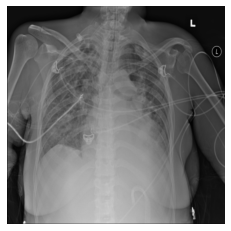

In [15]:
plt.imshow(
    inv_data_transform(
        testloader.dataset[0][0]
    )
)
plt.axis('off');

In [16]:
len(trainloaders[0].dataset), len(valloaders[0].dataset) ,len(testloader.dataset)

(959, 106, 5607)

In [17]:
len(all_labels)

13

### FL utils basic

In [18]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        # Read values from config
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]

        # Use values provided by the config
        print(f"[Client {self.cid}, round {server_round}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=local_epochs)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

### FL training utils

In [19]:
def compute_class_freqs(labels):

    labels = np.array(labels)
    N = labels.shape[0]

    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

def weighted_loss(pos_weights, neg_weights, y_pred, y_true, epsilon = 1e-7):
    y_pred = torch.sigmoid(y_pred)
    loss = 0.0
    for i in range(len(pos_weights)):
        loss_pos = -1 * torch.mean(pos_weights[i] * y_true[:,i] * torch.log(y_pred[:,i] + epsilon))
        loss_neg = -1 * torch.mean(neg_weights[i] * (1-y_true[:,i]) * torch.log((1-y_pred[:,i]) + epsilon))
        loss += loss_pos + loss_neg
    return loss

def train(
    net,
    trainloader,
    epochs
    ):
    print(f'Entered train function, total num. of epochs: {epochs}')
    # ToDo: Class weights should be different for each client
    freq_pos, freq_neg = compute_class_freqs(all_xray_df.iloc[:,-1])    
    pos_weights = freq_neg
    neg_weights = freq_pos

    valid_loss_min = np.Inf
    optimizer = torch.optim.Adam(
        net.parameters(),
        lr = 1e-4
        )
    start_time = time.time()
    for i in range(epochs):
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc = 0.0 
        net.train()
        for j, (images, labels) in enumerate(trainloader):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            ps = net(images)
            
            loss = weighted_loss(pos_weights, neg_weights, ps, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(trainloader)
        print("Epoch : {} Train Loss : {:.6f} ".format(i+1,avg_train_loss))
    end_time = time.time()
    time_delta = end_time - start_time
    print('\n')
    print(f'Time to complete local training round: {time_delta}')
    print('\n')

def test(net, testloader, pathology_list):
    
    # ToDo: Class weights should be different for each client
    freq_pos, freq_neg = compute_class_freqs(all_xray_df.iloc[:,-1])    
    pos_weights = freq_neg
    neg_weights = freq_pos

    per_class_accuracy = [0 for i in range(len(pathology_list))]
    total = 0.0
    loss = 0.0
    with torch.no_grad():
        for images,labels in testloader:
            ps = net(images.to(DEVICE))
            labels = labels.to(DEVICE)
            loss += weighted_loss( pos_weights, neg_weights, ps, labels)
            ps = (ps >= 0.5).float()

            for i in range(ps.shape[1]):
                x1 = ps[:,i:i+1]
                x2 = labels[:,i:i+1]
                per_class_accuracy[i] += int((x1 == x2).sum())

        per_class_accuracy = [(i/len(testloader.dataset)) * 100.0 for i in per_class_accuracy]

    return loss, np.mean(per_class_accuracy)

def get_acc_data(
    class_names,
    acc_list
    ):
    df = pd.DataFrame(list(zip(class_names, acc_list)), columns =['Labels', 'Class Acc.']) 
    return df

In [20]:
def server_eval(
    server_round: int,
    parameters: fl.common.NDArrays, 
    config: Dict[str, fl.common.Scalar]
    ):
    # ToDo: Class weights should be different for each client
    freq_pos, freq_neg = compute_class_freqs(all_xray_df.iloc[:,-1])    
    pos_weights = freq_neg
    neg_weights = freq_pos

    net = init_net().to(DEVICE)

    set_parameters(net, parameters)  # Update model with the latest parameters

    per_class_accuracy = [0 for i in range(len(all_labels))]
    total = 0.0
    loss = 0.0
    with torch.no_grad():
        for images,labels in testloader:
          
            ps = net(images.to(DEVICE))
            labels = labels.to(DEVICE)
            ps = torch.sigmoid(ps)
            ps = (ps >= 0.5).float()
            loss += weighted_loss( pos_weights, neg_weights, ps, labels)

            for i in range(ps.shape[1]):
                x1 = ps[:,i:i+1]
                x2 = labels[:,i:i+1]
                per_class_accuracy[i] += int((x1 == x2).sum())

        per_class_accuracy = [(i/len(testloader.dataset))*100.0 for i in per_class_accuracy]

    test_df = get_acc_data(all_labels, per_class_accuracy)
    print('\nServer eval')
    print(test_df)
    print('\n')

    return loss,  {"mean_class_acc.": np.mean(per_class_accuracy)}

## Training

In [21]:
def init_net():
  net = models.vgg11(
    weights="IMAGENET1K_V1"
  )
  net.classifier[-1] = torch.nn.Linear(
      net.classifier[-1].in_features,
      len(all_labels)
  )
  return net

def client_fn(cid) -> FlowerClient:
    net = init_net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    print(f'Created client: {cid}')
    return FlowerClient(cid, net, trainloader, valloader)

### 35 local epochs take approx 15min. on A100 for each client and 30 local epochs on Tesla T4 

Need to fix freeing GPU space after instances have been created and trained

In [22]:
num_rounds = 10
local_epochs = 30
fraction_fit = 0.05
fraction_evaluate = 0.05
min_fit_clients = 4
min_evaluate_clients = 4

client_resources = {
    "num_cpus": 1,
    "num_gpus": 1
    }

def fit_config(server_round: int):    
    config = {
        "server_round": server_round,
        "local_epochs": local_epochs,
    }
    return config

# Create an instance of the model and get the parameters
net = init_net()
params = get_parameters(init_net())

# Pass parameters to the Strategy for server-side parameter initialization
strategy = fl.server.strategy.FedAvg(
    fraction_fit=fraction_fit,
    fraction_evaluate=fraction_evaluate,
    min_fit_clients=min_fit_clients,
    min_evaluate_clients=min_evaluate_clients,
    min_available_clients=num_clients,
    initial_parameters=fl.common.ndarrays_to_parameters(params),
    evaluate_fn=server_eval,
    on_fit_config_fn=fit_config,
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=num_clients,
    client_resources=client_resources,
    config=fl.server.ServerConfig(num_rounds=num_rounds),
    strategy=strategy,
)

INFO flower 2022-10-22 23:25:45,005 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flower:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flower 2022-10-22 23:25:47,917 | app.py:179 | Flower VCE: Ray initialized with resources: {'object_store_memory': 16323267379.0, 'GPU': 1.0, 'accelerator_type:T4': 1.0, 'memory': 32646534759.0, 'CPU': 8.0, 'node:172.28.0.2': 1.0}
INFO:flower:Flower VCE: Ray initialized with resources: {'object_store_memory': 16323267379.0, 'GPU': 1.0, 'accelerator_type:T4': 1.0, 'memory': 32646534759.0, 'CPU': 8.0, 'node:172.28.0.2': 1.0}
INFO flower 2022-10-22 23:25:47,921 | server.py:86 | Initializing global parameters
INFO:flower:Initializing global parameters
INFO flower 2022-10-22 23:25:47,923 | server.py:266 | Using initial parameters provided by strategy
INFO:flower:Using initial parameters provided by strategy
INFO flower 2022-10-22 23:25:47,926 | server.py:88 | 


Server eval
                Labels  Class Acc.
0          Atelectasis   21.687177
1         Cardiomegaly   70.964865
2        Consolidation   37.328340
3                Edema   25.860531
4             Effusion   82.842875
5            Emphysema   66.916355
6             Fibrosis   66.292135
7         Infiltration   21.490993
8                 Mass   38.862137
9               Nodule   39.147494
10  Pleural_Thickening   40.895309
11           Pneumonia   70.126627
12        Pneumothorax   78.419832


(launch_and_fit pid=7807) Created client: 75
(launch_and_fit pid=7807) [Client 75, round 1] fit, config: {'server_round': 1, 'local_epochs': 30}
(launch_and_fit pid=7807) Entered train function, total num. of epochs: 30
(launch_and_fit pid=7807) Epoch : 1 Train Loss : 0.925058 
(launch_and_fit pid=7807) Epoch : 2 Train Loss : 0.908440 
(launch_and_fit pid=7807) Epoch : 3 Train Loss : 0.891319 
(launch_and_fit pid=7807) Epoch : 4 Train Loss : 0.844204 
(launch_and_fit pid=7807) Epoch : 5 Tra

DEBUG flower 2022-10-22 23:45:24,370 | server.py:234 | fit_round 1 received 1 results and 4 failures
DEBUG:flower:fit_round 1 received 1 results and 4 failures
WARNING flower 2022-10-22 23:45:25,842 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
INFO flower 2022-10-22 23:49:04,342 | server.py:122 | fit progress: (1, tensor(204.3126, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 91.9578548792032}, 1164.4134299650004)
INFO:flower:fit progress: (1, tensor(204.3126, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 91.9578548792032}, 1164.4134299650004)
DEBUG flower 2022-10-22 23:49:04,347 | server.py:170 | evaluate_round 1: strategy sampled 5 clients (out of 100)
DEBUG:flower:evaluate_round 1: strategy sampled 5 clients (out of 100)



Server eval
                Labels  Class Acc.
0          Atelectasis   89.673622
1         Cardiomegaly   95.559123
2        Consolidation   93.222757
3                Edema   91.617621
4             Effusion   88.603531
5            Emphysema   95.701801
6             Fibrosis   97.752809
7         Infiltration   64.901017
8                 Mass   94.417692
9               Nodule   94.150169
10  Pleural_Thickening   96.914571
11           Pneumonia   98.038167
12        Pneumothorax   94.899233


(launch_and_evaluate pid=8529) Created client: 19
(launch_and_evaluate pid=8529) [Client 19] evaluate, config: {}


(launch_and_fit pid=8105) E1022 23:49:32.669697872    8133 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=8564) Created client: 78


DEBUG flower 2022-10-22 23:49:37,517 | server.py:184 | evaluate_round 1 received 0 results and 5 failures
DEBUG:flower:evaluate_round 1 received 0 results and 5 failures
DEBUG flower 2022-10-22 23:49:37,520 | server.py:220 | fit_round 2: strategy sampled 5 clients (out of 100)
DEBUG:flower:fit_round 2: strategy sampled 5 clients (out of 100)


(launch_and_evaluate pid=8564) [Client 78] evaluate, config: {}


(launch_and_fit pid=8138) E1022 23:49:45.018542275    8168 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=8631) Created client: 41
(launch_and_fit pid=8631) [Client 41, round 2] fit, config: {'server_round': 2, 'local_epochs': 30}
(launch_and_fit pid=8631) Entered train function, total num. of epochs: 30
(launch_and_fit pid=8631) Epoch : 1 Train Loss : 1.058468 
(launch_and_fit pid=8631) Epoch : 2 Train Loss : 0.801285 
(launch_and_fit pid=8631) Epoch : 3 Train Loss : 0.782127 
(launch_and_fit pid=8631) Epoch : 4 Train Loss : 0.734165 
(launch_and_fit pid=8631) Epoch : 5 Train Loss : 0.687351 
(launch_and_fit pid=8631) Epoch : 6 Train Loss : 0.597617 
(launch_and_fit pid=8631) Epoch : 7 Train Loss : 0.558568 
(launch_and_fit pid=8631) Epoch : 8 Train Loss : 0.550062 
(launch_and_fit pid=8631) Epoch : 9 Train Loss : 0.461864 
(launch_and_fit pid=8631) Epoch : 10 Train Loss : 0.418315 
(launch_and_fit pid=8631) Epoch : 11 Train Loss : 0.336207 
(launch_and_fit pid=8631) Epoch : 12 Train Loss : 0.316779 
(launch_and_fit pid=8631) Epoch : 13 Train Loss : 0.282450 
(launch_a

DEBUG flower 2022-10-23 00:05:29,267 | server.py:234 | fit_round 2 received 1 results and 4 failures
DEBUG:flower:fit_round 2 received 1 results and 4 failures
INFO flower 2022-10-23 00:09:11,882 | server.py:122 | fit progress: (2, tensor(203.3134, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 90.77526717976156}, 2371.952882603)
INFO:flower:fit progress: (2, tensor(203.3134, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 90.77526717976156}, 2371.952882603)
DEBUG flower 2022-10-23 00:09:11,888 | server.py:170 | evaluate_round 2: strategy sampled 5 clients (out of 100)
DEBUG:flower:evaluate_round 2: strategy sampled 5 clients (out of 100)



Server eval
                Labels  Class Acc.
0          Atelectasis   89.477439
1         Cardiomegaly   96.825397
2        Consolidation   95.434279
3                Edema   93.187088
4             Effusion   88.567862
5            Emphysema   96.379526
6             Fibrosis   96.112003
7         Infiltration   80.042804
8                 Mass   64.829677
9               Nodule   93.829142
10  Pleural_Thickening   96.201177
11           Pneumonia   96.932406
12        Pneumothorax   92.259675


(launch_and_evaluate pid=9375) Created client: 47
(launch_and_evaluate pid=9375) [Client 47] evaluate, config: {}
(launch_and_evaluate pid=9410) Created client: 39
(launch_and_evaluate pid=9410) [Client 39] evaluate, config: {}
(scheduler +48m48s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(launch_

(launch_and_fit pid=9027) E1023 00:09:43.622031504    9055 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=9483) Created client: 84


DEBUG flower 2022-10-23 00:09:48,845 | server.py:184 | evaluate_round 2 received 0 results and 5 failures
DEBUG:flower:evaluate_round 2 received 0 results and 5 failures
DEBUG flower 2022-10-23 00:09:48,849 | server.py:220 | fit_round 3: strategy sampled 5 clients (out of 100)
DEBUG:flower:fit_round 3: strategy sampled 5 clients (out of 100)


(launch_and_evaluate pid=9483) [Client 84] evaluate, config: {}
(launch_and_fit pid=9622) Created client: 96
(launch_and_fit pid=9622) [Client 96, round 3] fit, config: {'server_round': 3, 'local_epochs': 30}
(launch_and_fit pid=9622) Entered train function, total num. of epochs: 30


(launch_and_fit pid=9093) E1023 00:10:06.728023046    9121 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(launch_and_fit pid=9125) E1023 00:10:10.665356409    9154 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=9783) Created client: 45
(launch_and_fit pid=9783) [Client 45, round 3] fit, config: {'server_round': 3, 'local_epochs': 30}
(launch_and_fit pid=9783) Entered train function, total num. of epochs: 30


DEBUG flower 2022-10-23 00:10:24,572 | server.py:234 | fit_round 3 received 0 results and 5 failures
DEBUG:flower:fit_round 3 received 0 results and 5 failures
INFO flower 2022-10-23 00:14:04,901 | server.py:122 | fit progress: (3, tensor(203.4800, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 90.82054025874251}, 2664.972284345)
INFO:flower:fit progress: (3, tensor(203.4800, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 90.82054025874251}, 2664.972284345)
DEBUG flower 2022-10-23 00:14:04,907 | server.py:170 | evaluate_round 3: strategy sampled 5 clients (out of 100)
DEBUG:flower:evaluate_round 3: strategy sampled 5 clients (out of 100)



Server eval
                Labels  Class Acc.
0          Atelectasis   89.477439
1         Cardiomegaly   96.682718
2        Consolidation   95.541288
3                Edema   93.561619
4             Effusion   88.532192
5            Emphysema   96.486535
6             Fibrosis   96.433030
7         Infiltration   80.060638
8                 Mass   64.597824
9               Nodule   93.882647
10  Pleural_Thickening   96.254682
11           Pneumonia   96.807562
12        Pneumothorax   92.348850


(launch_and_evaluate pid=9938) Created client: 50
(launch_and_evaluate pid=9938) [Client 50] evaluate, config: {}


(launch_and_evaluate pid=9448) E1023 00:14:19.366042446    9476 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=10033) Created client: 49
(launch_and_evaluate pid=10033) [Client 49] evaluate, config: {}


(launch_and_evaluate pid=9483) E1023 00:14:25.496527288    9511 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=10069) Created client: 19
(launch_and_evaluate pid=10069) [Client 19] evaluate, config: {}


(launch_and_fit pid=9622) E1023 00:14:31.512554379    9674 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=10105) Created client: 29
(launch_and_evaluate pid=10105) [Client 29] evaluate, config: {}


(launch_and_fit pid=9683) E1023 00:14:37.297088732    9711 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=10142) Created client: 80


DEBUG flower 2022-10-23 00:14:42,559 | server.py:184 | evaluate_round 3 received 0 results and 5 failures
DEBUG:flower:evaluate_round 3 received 0 results and 5 failures
DEBUG flower 2022-10-23 00:14:42,562 | server.py:220 | fit_round 4: strategy sampled 5 clients (out of 100)
DEBUG:flower:fit_round 4: strategy sampled 5 clients (out of 100)


(launch_and_evaluate pid=10142) [Client 80] evaluate, config: {}


(launch_and_fit pid=9716) E1023 00:14:50.647045824    9744 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(launch_and_fit pid=9750) E1023 00:14:55.826337444    9778 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=10374) Created client: 41
(launch_and_fit pid=10374) [Client 41, round 4] fit, config: {'server_round': 4, 'local_epochs': 30}
(launch_and_fit pid=10374) Entered train function, total num. of epochs: 30
(launch_and_fit pid=10410) Created client: 92
(launch_and_fit pid=10410) [Client 92, round 4] fit, config: {'server_round': 4, 'local_epochs': 30}
(launch_and_fit pid=10410) Entered train function, total num. of epochs: 30
(launch_and_fit pid=10447) Created client: 3
(launch_and_fit pid=10447) [Client 3, round 4] fit, config: {'server_round': 4, 'local_epochs': 30}
(launch_and_fit pid=10447) Entered train function, total num. of epochs: 30


DEBUG flower 2022-10-23 00:15:19,329 | server.py:234 | fit_round 4 received 0 results and 5 failures
DEBUG:flower:fit_round 4 received 0 results and 5 failures
INFO flower 2022-10-23 00:18:59,093 | server.py:122 | fit progress: (4, tensor(203.3773, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 90.81779643577397}, 2959.164405261)
INFO:flower:fit progress: (4, tensor(203.3773, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 90.81779643577397}, 2959.164405261)
DEBUG flower 2022-10-23 00:18:59,099 | server.py:170 | evaluate_round 4: strategy sampled 5 clients (out of 100)
DEBUG:flower:evaluate_round 4: strategy sampled 5 clients (out of 100)



Server eval
                Labels  Class Acc.
0          Atelectasis   89.388265
1         Cardiomegaly   96.771892
2        Consolidation   95.452113
3                Edema   93.454610
4             Effusion   88.532192
5            Emphysema   96.290351
6             Fibrosis   96.201177
7         Infiltration   79.900125
8                 Mass   65.097200
9               Nodule   93.722133
10  Pleural_Thickening   96.308186
11           Pneumonia   97.110754
12        Pneumothorax   92.402354




(launch_and_evaluate pid=10069) E1023 00:19:08.430941300   10097 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=10614) Created client: 31
(launch_and_evaluate pid=10614) [Client 31] evaluate, config: {}


(launch_and_evaluate pid=10105) E1023 00:19:14.613679067   10134 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=10699) Created client: 94
(launch_and_evaluate pid=10699) [Client 94] evaluate, config: {}


(launch_and_evaluate pid=10142) E1023 00:19:20.320318962   10170 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=10735) Created client: 35
(launch_and_evaluate pid=10735) [Client 35] evaluate, config: {}


(launch_and_fit pid=10240) E1023 00:19:26.444921717   10280 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(launch_and_fit pid=10340) E1023 00:19:31.612960953   10368 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
DEBUG flower 2022-10-23 00:19:34,858 | server.py:184 | evaluate_round 4 received 0 results and 5 failures
DEBUG:flower:evaluate_round 4 received 0 results and 5 failures
DEBUG flower 2022-10-23 00:19:34,862 | server.py:220 | fit_round 5: strategy sampled 5 clients (out of 100)
DEBUG:flower:fit_round 5: strategy sampled 5 clients (out of 100)
(launch_and_fit pid=10374) E1023 00:19:43.379005365   10402 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=10930) Created client: 84
(launch_and_fit pid=10930) [Client 84, round 5] fit, config: {'server_round': 5, 'local_epochs': 30}
(launch_and_fit pid=10930) Entered train function, total num. of epochs: 30


(launch_and_fit pid=10410) E1023 00:19:50.163890645   10439 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=11005) Created client: 68
(launch_and_fit pid=11005) [Client 68, round 5] fit, config: {'server_round': 5, 'local_epochs': 30}
(launch_and_fit pid=11005) Entered train function, total num. of epochs: 30
(launch_and_fit pid=11042) Created client: 34
(launch_and_fit pid=11042) [Client 34, round 5] fit, config: {'server_round': 5, 'local_epochs': 30}
(launch_and_fit pid=11042) Entered train function, total num. of epochs: 30
(launch_and_fit pid=11079) Created client: 54
(launch_and_fit pid=11079) [Client 54, round 5] fit, config: {'server_round': 5, 'local_epochs': 30}
(launch_and_fit pid=11079) Entered train function, total num. of epochs: 30
(launch_and_fit pid=11115) Created client: 49
(launch_and_fit pid=11115) [Client 49, round 5] fit, config: {'server_round': 5, 'local_epochs': 30}
(launch_and_fit pid=11115) Entered train function, total num. of epochs: 30


DEBUG flower 2022-10-23 00:20:16,642 | server.py:234 | fit_round 5 received 0 results and 5 failures
DEBUG:flower:fit_round 5 received 0 results and 5 failures
INFO flower 2022-10-23 00:23:58,692 | server.py:122 | fit progress: (5, tensor(203.3168, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 90.87267289514482}, 3258.763369176001)
INFO:flower:fit progress: (5, tensor(203.3168, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 90.87267289514482}, 3258.763369176001)
DEBUG flower 2022-10-23 00:23:58,698 | server.py:170 | evaluate_round 5: strategy sampled 5 clients (out of 100)
DEBUG:flower:evaluate_round 5: strategy sampled 5 clients (out of 100)



Server eval
                Labels  Class Acc.
0          Atelectasis   89.459604
1         Cardiomegaly   96.932406
2        Consolidation   95.559123
3                Edema   93.632959
4             Effusion   88.514357
5            Emphysema   96.415195
6             Fibrosis   96.254682
7         Infiltration   79.900125
8                 Mass   64.686998
9               Nodule   93.757803
10  Pleural_Thickening   96.343856
11           Pneumonia   97.128589
12        Pneumothorax   92.759051




(launch_and_evaluate pid=10735) E1023 00:24:06.728545808   10763 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=11258) Created client: 15
(launch_and_evaluate pid=11258) [Client 15] evaluate, config: {}


(launch_and_evaluate pid=10771) E1023 00:24:12.963929680   10799 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(launch_and_evaluate pid=10805) E1023 00:24:18.267776021   10833 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(launch_and_fit pid=10930) E1023 00:24:22.142302994   10964 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=11434) Created client: 34
(launch_and_evaluate pid=11434) [Client 34] evaluate, config: {}
(launch_and_evaluate pid=11471) Created client: 22


DEBUG flower 2022-10-23 00:24:33,087 | server.py:184 | evaluate_round 5 received 0 results and 5 failures
DEBUG:flower:evaluate_round 5 received 0 results and 5 failures
DEBUG flower 2022-10-23 00:24:33,091 | server.py:220 | fit_round 6: strategy sampled 5 clients (out of 100)
DEBUG:flower:fit_round 6: strategy sampled 5 clients (out of 100)


(launch_and_evaluate pid=11471) [Client 22] evaluate, config: {}


(launch_and_fit pid=11042) E1023 00:24:40.839547085   11071 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=11560) Created client: 50
(launch_and_fit pid=11560) [Client 50, round 6] fit, config: {'server_round': 6, 'local_epochs': 30}
(launch_and_fit pid=11560) Entered train function, total num. of epochs: 30


(launch_and_fit pid=11079) E1023 00:24:47.739363787   11107 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=11670) Created client: 47
(launch_and_fit pid=11670) [Client 47, round 6] fit, config: {'server_round': 6, 'local_epochs': 30}
(launch_and_fit pid=11670) Entered train function, total num. of epochs: 30


(launch_and_fit pid=11115) E1023 00:24:54.798737548   11143 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=11709) Created client: 18
(launch_and_fit pid=11709) [Client 18, round 6] fit, config: {'server_round': 6, 'local_epochs': 30}
(launch_and_fit pid=11709) Entered train function, total num. of epochs: 30
(launch_and_fit pid=11746) Created client: 26
(launch_and_fit pid=11746) [Client 26, round 6] fit, config: {'server_round': 6, 'local_epochs': 30}
(launch_and_fit pid=11746) Entered train function, total num. of epochs: 30


DEBUG flower 2022-10-23 00:25:12,818 | server.py:234 | fit_round 6 received 0 results and 5 failures
DEBUG:flower:fit_round 6 received 0 results and 5 failures
INFO flower 2022-10-23 00:28:52,716 | server.py:122 | fit progress: (6, tensor(203.6063, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 90.8356312850695}, 3552.787498017001)
INFO:flower:fit progress: (6, tensor(203.6063, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 90.8356312850695}, 3552.787498017001)
DEBUG flower 2022-10-23 00:28:52,722 | server.py:170 | evaluate_round 6: strategy sampled 5 clients (out of 100)
DEBUG:flower:evaluate_round 6: strategy sampled 5 clients (out of 100)



Server eval
                Labels  Class Acc.
0          Atelectasis   89.441769
1         Cardiomegaly   96.807562
2        Consolidation   95.559123
3                Edema   93.953986
4             Effusion   88.621366
5            Emphysema   96.611379
6             Fibrosis   96.254682
7         Infiltration   79.543428
8                 Mass   65.008026
9               Nodule   93.686463
10  Pleural_Thickening   96.236847
11           Pneumonia   96.807562
12        Pneumothorax   92.331015




(launch_and_evaluate pid=11401) E1023 00:29:01.085087960   11429 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(launch_and_evaluate pid=11434) E1023 00:29:05.305585896   11462 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=12029) Created client: 26
(launch_and_evaluate pid=12029) [Client 26] evaluate, config: {}


(launch_and_evaluate pid=11471) E1023 00:29:11.346295078   11499 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=12065) Created client: 58
(launch_and_evaluate pid=12065) [Client 58] evaluate, config: {}
(scheduler +1h8m25s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(launch_and_fit pid=11560) E1023 00:29:17.275111301   11630 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=12101) Created client: 19
(launch_and_evaluate pid=12101) [Client 19] evaluate, config: {}


(launch_and_fit pid=11670) E1023 00:29:23.487487001   11698 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=12138) Created client: 12


DEBUG flower 2022-10-23 00:29:28,634 | server.py:184 | evaluate_round 6 received 0 results and 5 failures
DEBUG:flower:evaluate_round 6 received 0 results and 5 failures
DEBUG flower 2022-10-23 00:29:28,638 | server.py:220 | fit_round 7: strategy sampled 5 clients (out of 100)
DEBUG:flower:fit_round 7: strategy sampled 5 clients (out of 100)


(launch_and_evaluate pid=12138) [Client 12] evaluate, config: {}


(launch_and_fit pid=11709) E1023 00:29:36.123089608   11737 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=12216) Created client: 11
(launch_and_fit pid=12216) [Client 11, round 7] fit, config: {'server_round': 7, 'local_epochs': 30}
(launch_and_fit pid=12216) Entered train function, total num. of epochs: 30
(launch_and_fit pid=12338) Created client: 44
(launch_and_fit pid=12338) [Client 44, round 7] fit, config: {'server_round': 7, 'local_epochs': 30}
(launch_and_fit pid=12338) Entered train function, total num. of epochs: 30


(launch_and_fit pid=11783) E1023 00:29:50.120376390   11811 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=12445) Created client: 16
(launch_and_fit pid=12445) [Client 16, round 7] fit, config: {'server_round': 7, 'local_epochs': 30}
(launch_and_fit pid=12445) Entered train function, total num. of epochs: 30


DEBUG flower 2022-10-23 00:30:05,483 | server.py:234 | fit_round 7 received 0 results and 5 failures
DEBUG:flower:fit_round 7 received 0 results and 5 failures
INFO flower 2022-10-23 00:33:44,669 | server.py:122 | fit progress: (7, tensor(203.4517, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 90.83837510803802}, 3844.740221469)
INFO:flower:fit progress: (7, tensor(203.4517, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 90.83837510803802}, 3844.740221469)
DEBUG flower 2022-10-23 00:33:44,675 | server.py:170 | evaluate_round 7: strategy sampled 5 clients (out of 100)
DEBUG:flower:evaluate_round 7: strategy sampled 5 clients (out of 100)



Server eval
                Labels  Class Acc.
0          Atelectasis   89.406100
1         Cardiomegaly   96.736223
2        Consolidation   95.559123
3                Edema   93.650794
4             Effusion   88.550027
5            Emphysema   96.165507
6             Fibrosis   96.450865
7         Infiltration   80.096308
8                 Mass   65.222044
9               Nodule   93.650794
10  Pleural_Thickening   96.112003
11           Pneumonia   97.075085
12        Pneumothorax   92.224006




(launch_and_evaluate pid=12065) E1023 00:33:53.338185005   12093 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=12623) Created client: 52
(launch_and_evaluate pid=12623) [Client 52] evaluate, config: {}


(launch_and_evaluate pid=12101) E1023 00:33:59.317920348   12129 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=12696) Created client: 62
(launch_and_evaluate pid=12696) [Client 62] evaluate, config: {}


(launch_and_evaluate pid=12138) E1023 00:34:05.327931845   12166 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=12734) Created client: 12
(launch_and_evaluate pid=12734) [Client 12] evaluate, config: {}


(launch_and_fit pid=12216) E1023 00:34:11.405302627   12268 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=12770) Created client: 8
(launch_and_evaluate pid=12770) [Client 8] evaluate, config: {}


(launch_and_fit pid=12338) E1023 00:34:17.348989448   12366 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=12806) Created client: 70


DEBUG flower 2022-10-23 00:34:22,564 | server.py:184 | evaluate_round 7 received 0 results and 5 failures
DEBUG:flower:evaluate_round 7 received 0 results and 5 failures
DEBUG flower 2022-10-23 00:34:22,566 | server.py:220 | fit_round 8: strategy sampled 5 clients (out of 100)
DEBUG:flower:fit_round 8: strategy sampled 5 clients (out of 100)


(launch_and_evaluate pid=12806) [Client 70] evaluate, config: {}


(launch_and_fit pid=12376) E1023 00:34:30.360244995   12404 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(launch_and_fit pid=12410) E1023 00:34:35.856039893   12438 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(launch_and_fit pid=12445) E1023 00:34:39.822427437   12473 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=13037) Created client: 1
(launch_and_fit pid=13037) [Client 1, round 8] fit, config: {'server_round': 8, 'local_epochs': 30}
(launch_and_fit pid=13037) Entered train function, total num. of epochs: 30
(launch_and_fit pid=13074) Created client: 82
(launch_and_fit pid=13074) [Client 82, round 8] fit, config: {'server_round': 8, 'local_epochs': 30}
(launch_and_fit pid=13074) Entered train function, total num. of epochs: 30
(launch_and_fit pid=13110) Created client: 96
(launch_and_fit pid=13110) [Client 96, round 8] fit, config: {'server_round': 8, 'local_epochs': 30}
(launch_and_fit pid=13110) Entered train function, total num. of epochs: 30


DEBUG flower 2022-10-23 00:34:59,260 | server.py:234 | fit_round 8 received 0 results and 5 failures
DEBUG:flower:fit_round 8 received 0 results and 5 failures
INFO flower 2022-10-23 00:38:37,867 | server.py:122 | fit progress: (8, tensor(203.5591, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 90.7972177635099}, 4137.937989357001)
INFO:flower:fit progress: (8, tensor(203.5591, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 90.7972177635099}, 4137.937989357001)
DEBUG flower 2022-10-23 00:38:37,872 | server.py:170 | evaluate_round 8: strategy sampled 5 clients (out of 100)
DEBUG:flower:evaluate_round 8: strategy sampled 5 clients (out of 100)



Server eval
                Labels  Class Acc.
0          Atelectasis   89.423934
1         Cardiomegaly   96.682718
2        Consolidation   95.416444
3                Edema   93.668629
4             Effusion   88.550027
5            Emphysema   96.219012
6             Fibrosis   96.112003
7         Infiltration   79.828785
8                 Mass   65.132870
9               Nodule   93.757803
10  Pleural_Thickening   96.183342
11           Pneumonia   97.110754
12        Pneumothorax   92.277510


(launch_and_evaluate pid=13230) Created client: 85
(launch_and_evaluate pid=13230) [Client 85] evaluate, config: {}


(launch_and_evaluate pid=12770) E1023 00:38:52.361854714   12798 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=13361) Created client: 12
(launch_and_evaluate pid=13361) [Client 12] evaluate, config: {}


(launch_and_evaluate pid=12806) E1023 00:38:58.366720507   12834 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=13397) Created client: 15
(launch_and_evaluate pid=13397) [Client 15] evaluate, config: {}


(launch_and_fit pid=12873) E1023 00:39:04.535802514   12973 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(launch_and_fit pid=13003) E1023 00:39:09.677732037   13031 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
DEBUG flower 2022-10-23 00:39:13,067 | server.py:184 | evaluate_round 8 received 0 results and 5 failures
DEBUG:flower:evaluate_round 8 received 0 results and 5 failures
DEBUG flower 2022-10-23 00:39:13,071 | server.py:220 | fit_round 9: strategy sampled 5 clients (out of 100)
DEBUG:flower:fit_round 9: strategy sampled 5 clients (out of 100)
(launch_and_fit pid=13037) E1023 00:39:21.980753322   13065 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=13606) Created client: 7
(launch_and_fit pid=13606) [Client 7, round 9] fit, config: {'server_round': 9, 'local_epochs': 30}
(launch_and_fit pid=13606) Entered train function, total num. of epochs: 30


(launch_and_fit pid=13074) E1023 00:39:28.767019979   13102 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=13667) Created client: 39
(launch_and_fit pid=13667) [Client 39, round 9] fit, config: {'server_round': 9, 'local_epochs': 30}
(launch_and_fit pid=13667) Entered train function, total num. of epochs: 30


(launch_and_fit pid=13110) E1023 00:39:35.493929586   13139 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=13705) Created client: 84
(launch_and_fit pid=13705) [Client 84, round 9] fit, config: {'server_round': 9, 'local_epochs': 30}
(launch_and_fit pid=13705) Entered train function, total num. of epochs: 30
(launch_and_fit pid=13742) Created client: 3
(launch_and_fit pid=13742) [Client 3, round 9] fit, config: {'server_round': 9, 'local_epochs': 30}
(launch_and_fit pid=13742) Entered train function, total num. of epochs: 30
(launch_and_fit pid=13779) Created client: 18
(launch_and_fit pid=13779) [Client 18, round 9] fit, config: {'server_round': 9, 'local_epochs': 30}
(launch_and_fit pid=13779) Entered train function, total num. of epochs: 30


DEBUG flower 2022-10-23 00:39:55,036 | server.py:234 | fit_round 9 received 0 results and 5 failures
DEBUG:flower:fit_round 9 received 0 results and 5 failures
INFO flower 2022-10-23 00:43:33,955 | server.py:122 | fit progress: (9, tensor(203.5880, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 90.81368070132115}, 4434.026296934001)
INFO:flower:fit progress: (9, tensor(203.5880, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 90.81368070132115}, 4434.026296934001)
DEBUG flower 2022-10-23 00:43:33,962 | server.py:170 | evaluate_round 9: strategy sampled 5 clients (out of 100)
DEBUG:flower:evaluate_round 9: strategy sampled 5 clients (out of 100)



Server eval
                Labels  Class Acc.
0          Atelectasis   89.548778
1         Cardiomegaly   96.825397
2        Consolidation   95.541288
3                Edema   93.739968
4             Effusion   88.585696
5            Emphysema   96.433030
6             Fibrosis   96.272516
7         Infiltration   79.900125
8                 Mass   64.883182
9               Nodule   93.739968
10  Pleural_Thickening   96.272516
11           Pneumonia   96.754057
12        Pneumothorax   92.081327


(launch_and_evaluate pid=13921) Created client: 56
(launch_and_evaluate pid=13921) [Client 56] evaluate, config: {}


(launch_and_evaluate pid=13434) E1023 00:43:47.786192182   13462 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(launch_and_evaluate pid=13470) E1023 00:43:53.178601479   13498 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(launch_and_fit pid=13606) E1023 00:43:57.425442947   13634 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(scheduler +1h23m6s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(launch_and_evaluate pid=14096) Created client: 94
(launch_and_evaluate pid=14096) [Client 94] evaluate, config: {}


(launch_and_fit pid=13667) E1023 00:44:03.545955256   13696 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=14132) Created client: 61


DEBUG flower 2022-10-23 00:44:08,443 | server.py:184 | evaluate_round 9 received 0 results and 5 failures
DEBUG:flower:evaluate_round 9 received 0 results and 5 failures
DEBUG flower 2022-10-23 00:44:08,447 | server.py:220 | fit_round 10: strategy sampled 5 clients (out of 100)
DEBUG:flower:fit_round 10: strategy sampled 5 clients (out of 100)


(launch_and_evaluate pid=14132) [Client 61] evaluate, config: {}


(launch_and_fit pid=13705) E1023 00:44:16.646012270   13733 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=14237) Created client: 35
(launch_and_fit pid=14237) [Client 35, round 10] fit, config: {'server_round': 10, 'local_epochs': 30}
(launch_and_fit pid=14237) Entered train function, total num. of epochs: 30


(launch_and_fit pid=13742) E1023 00:44:23.610466345   13770 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=14334) Created client: 81
(launch_and_fit pid=14334) [Client 81, round 10] fit, config: {'server_round': 10, 'local_epochs': 30}
(launch_and_fit pid=14334) Entered train function, total num. of epochs: 30


(launch_and_fit pid=13779) E1023 00:44:30.470995255   13807 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=14372) Created client: 62
(launch_and_fit pid=14372) [Client 62, round 10] fit, config: {'server_round': 10, 'local_epochs': 30}
(launch_and_fit pid=14372) Entered train function, total num. of epochs: 30
(scheduler +1h23m46s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(launch_and_fit pid=14409) Created client: 66
(launch_and_fit pid=14409) [Client 66, round 10] fit, config: {'server_round': 10, 'local_epochs': 30}
(launch_and_fit pid=14409) Entered train function, total num. of epochs: 30


DEBUG flower 2022-10-23 00:44:48,652 | server.py:234 | fit_round 10 received 0 results and 5 failures
DEBUG:flower:fit_round 10 received 0 results and 5 failures
INFO flower 2022-10-23 00:48:28,835 | server.py:122 | fit progress: (10, tensor(203.3237, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 90.84660657694366}, 4728.9061773309995)
INFO:flower:fit progress: (10, tensor(203.3237, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 90.84660657694366}, 4728.9061773309995)
DEBUG flower 2022-10-23 00:48:28,841 | server.py:170 | evaluate_round 10: strategy sampled 5 clients (out of 100)
DEBUG:flower:evaluate_round 10: strategy sampled 5 clients (out of 100)



Server eval
                Labels  Class Acc.
0          Atelectasis   89.406100
1         Cardiomegaly   96.825397
2        Consolidation   95.666132
3                Edema   93.525950
4             Effusion   88.478687
5            Emphysema   96.236847
6             Fibrosis   96.147673
7         Infiltration   80.203317
8                 Mass   65.097200
9               Nodule   93.811307
10  Pleural_Thickening   96.415195
11           Pneumonia   96.861067
12        Pneumothorax   92.331015




(launch_and_evaluate pid=14062) E1023 00:48:36.354447384   14090 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(launch_and_evaluate pid=14096) E1023 00:48:40.516335951   14124 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=14704) Created client: 1
(launch_and_evaluate pid=14704) [Client 1] evaluate, config: {}


(launch_and_evaluate pid=14132) E1023 00:48:46.514070343   14160 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=14740) Created client: 85
(launch_and_evaluate pid=14740) [Client 85] evaluate, config: {}


(launch_and_fit pid=14237) E1023 00:48:52.532933553   14283 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=14776) Created client: 71
(launch_and_evaluate pid=14776) [Client 71] evaluate, config: {}


(launch_and_fit pid=14334) E1023 00:48:58.538116946   14362 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=14812) Created client: 59


DEBUG flower 2022-10-23 00:49:03,693 | server.py:184 | evaluate_round 10 received 0 results and 5 failures
DEBUG:flower:evaluate_round 10 received 0 results and 5 failures
INFO flower 2022-10-23 00:49:03,697 | server.py:144 | FL finished in 4763.767980044001
INFO:flower:FL finished in 4763.767980044001
INFO flower 2022-10-23 00:49:03,703 | app.py:180 | app_fit: losses_distributed []
INFO:flower:app_fit: losses_distributed []
INFO flower 2022-10-23 00:49:03,705 | app.py:181 | app_fit: metrics_distributed {}
INFO:flower:app_fit: metrics_distributed {}
INFO flower 2022-10-23 00:49:03,716 | app.py:182 | app_fit: losses_centralized [(0, tensor(223.4551, device='cuda:0', dtype=torch.float64)), (1, tensor(204.3126, device='cuda:0', dtype=torch.float64)), (2, tensor(203.3134, device='cuda:0', dtype=torch.float64)), (3, tensor(203.4800, device='cuda:0', dtype=torch.float64)), (4, tensor(203.3773, device='cuda:0', dtype=torch.float64)), (5, tensor(203.3168, device='cuda:0', dtype=torch.float64))

(launch_and_evaluate pid=14812) [Client 59] evaluate, config: {}


History (loss, centralized):
	round 0: 223.45512947997756
	round 1: 204.31259566194032
	round 2: 203.31344774777983
	round 3: 203.47996789953805
	round 4: 203.3773132904075
	round 5: 203.3167755084395
	round 6: 203.60628504297932
	round 7: 203.45169279565297
	round 8: 203.55913607907542
	round 9: 203.5880096568752
	round 10: 203.32374443204128
History (metrics, centralized):
{'mean_class_acc.': [(0, 50.833436226694644), (1, 91.9578548792032), (2, 90.77526717976156), (3, 90.82054025874251), (4, 90.81779643577397), (5, 90.87267289514482), (6, 90.8356312850695), (7, 90.83837510803802), (8, 90.7972177635099), (9, 90.81368070132115), (10, 90.84660657694366)]}